# Lewinson Chapter 7 - Asset Allocation in Python

## Introduction

Chapter 7 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) covers portfolios returns and optimization.

We will focus on:

1. Evaluating $\frac{1}{n}$ portfolios (i.e., equal-weighted portfolios)
1. Using SciPy's optimizer to find the efficient frontier
1. Using SciPy's optimizer to achieve any objective

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')
import yfinance as yf
import pandas_datareader as pdr

## Evaluating the performance of a basic 1/n portfolio

> We begin with inspecting the most basic asset allocation strategy: the 1/n portfolio. The idea is to assign equal weights to all the considered assets, thus diversifying the portfolio. As simple as that might sound, DeMiguel, Garlappi, and Uppal (2007) show that it can be difficult to beat the performance of the 1/n portfolio by using more advanced asset allocation strategies.
>
> The goal of the recipe is to show how to create a 1/n portfolio, calculate its returns, and then use a Python library called pyfolio to quickly obtain all relevant portfolio evaluation metrics in the form of a tear sheet. Historically, a tear sheet is a concise, usually one-page, document, summarizing important information about public companies.

We will not use `pyfolio`, which appears to be abandoned.

We will follow Lewinson's structure, although I prefer to download all data first then slice or subset it later.
These data are small (kilobytes instead of megabytes or gigabytes), so we might as well download all data then slice or subset it when necessary.

In [4]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT', 'TWTR']
START_DATE = '2017-01-01'
END_DATE = '2018-12-31'

In [5]:
df = yf.download(tickers=RISKY_ASSETS, session=session)
df.index = df.index.tz_localize(None)

[*********************100%***********************]  4 of 4 completed


In [6]:
returns = df['Adj Close'].pct_change().loc[START_DATE:END_DATE]

Before we do portfolio math, we can make $\frac{1}{n}$ portfolios "by hand".
The following code creates an equally-weighted and daily-rebalanced portfolio of our four stocks.

In [7]:
p1 = 0.25*returns['AAPL'] + 0.25*returns['IBM'] + 0.25*returns['MSFT'] + 0.25*returns['TWTR']

In [8]:
p2 = 0.25 * returns.sum(axis=1)

In [9]:
np.allclose(p1, p2)

True

In [10]:
p3 = returns.mean(axis=1)

In [11]:
np.allclose(p1, p3)

True

***Note that when we apply the same portfolio weights every day, we rebalance at the same frequency as the returns data.***
If we have daily data, rebalance daily.
If we have monthly data, we rebalance monthly, and so on.

In [12]:
returns.shape

(502, 4)

In [13]:
portfolio_weights = np.ones(returns.shape[1]) / returns.shape[1]

In [14]:
portfolio_weights

array([0.25, 0.25, 0.25, 0.25])

The following notation is more compact than Lewinson's notation and generates the same output:
$$
R_P = \omega^T R,
$$
where $R_P$ is a vector of portfolio returns, $\omega$ is a vector of portfolio weights, and $R$ is a matrix of individual stock or asset returns.

In [15]:
portfolio_returns = returns.dot(portfolio_weights)

In [16]:
np.allclose(p1, portfolio_returns)

True

---

Here is a simple example to help understand the `.dot()` method.

In [17]:
silly = pd.DataFrame(np.arange(8).reshape(2, 4))
silly

,0,1,2,3
0,0,1,2,3
1,4,5,6,7


In [18]:
silly.dot(portfolio_weights)

0   1.5000
1   5.5000
dtype: float64

In [19]:
zero_row = silly.iloc[0, 0]*portfolio_weights[0] + silly.iloc[0, 1]*portfolio_weights[1] + silly.iloc[0, 2]*portfolio_weights[2] + silly.iloc[0, 3]*portfolio_weights[3]
print(f'The zero row is: {zero_row}')

The zero row is: 1.5


In [20]:
silly_weights = np.array([1, 0, 0, 0])

In [21]:
silly.dot(silly_weights)

0    0
1    4
dtype: int64

In [22]:
np.allclose(returns['AAPL'], returns.dot(silly_weights))

True

---

## Finding the Efficient Frontier using Monte Carlo simulations

> According to the Modern Portfolio Theory, the Efficient Frontier is a set of optimal portfolios in the risk-return spectrum. This means that the portfolios on the frontier:
> 
> - Offer the highest expected return for a given level of risk
> - Offer the lowest level of risk for a given level of expected returns
> 
> All portfolios located under the Efficient Frontier curve are considered sub-optimal, so it is always better to choose the ones on the frontier instead.
> 
> In this recipe, we show how to find the Efficient Frontier using Monte Carlo simulations. We build thousands of portfolios, using randomly assigned weights, and visualize the results. To do so, we use the returns of four US tech companies from 2018.

We will skip Lewinson's Monte Carlo simulation of the efficient frontier.
This simulation is sometimes enlightening, but often creates bad habits.
Therefore, we will jump right to using the optimizer to find the efficient frontier.

## A Crash Course in scipy's minimize() Function

The `sco.minimize()` function iteratively finds the input array `x` that minimizes the output of function `fun`.
We pass our first guess for the input array `x` to the argument `x0=`.
We pass additional arguments for the function `fun` as a tuple to the argument `args=`.
We pass the lower and upper bounds on `x` as a tuple of tuples to the argument `bounds=`.
We contrain our results with a tuple of dictionaries of functions to the argument`contraints=`.

Here is a simple example that minimizes the `quadratic()` function $y = (x - a)^2$ where $a=5$.

In [23]:
import scipy.optimize as sco

In [24]:
def quadratic(x, a=5):
    return (x - a) ** 2

The minimum output of `quadratic()` occurs at $x=5$ if we do not use bounds or constraints.

In [25]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001])
)

      fun: 2.0392713450495178e-16
 hess_inv: array([[0.5]])
      jac: array([-1.3659e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([5.])

The minimum output of `quadratic()` occurs at $x=6$ if we bound `x` between 6 and 10 (i.e., $6 \leq x \leq 10$).

In [26]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    bounds=((6, 10),)
)

      fun: 1.0
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([6.])

Finally, the minimum output of `quadratic()` occurs at $x=6$, again, if we bound `x` between 5 and 10 and constrain `x - 6` to be non-negative.
We use bounds to limit the search space directly, and we use constraints to limit the search space indirectly, based on some formula.

In [27]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    bounds=((5, 10),),
    constraints=({'type': 'ineq', 'fun': lambda x: x - 6})
)

     fun: 1.0000000000001776
     jac: array([2.])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([6.])

Finally, we can use the `args=` argument to pass additional arguments to `fun`.
Here we change the `a=` argument in `quadratic()` from the default of `a=5` to `a=20` via `args=(20,)`.
Note that `args=` expects a tuple, so we need a trailing comma `,` if we only have one argument.

In [28]:
sco.minimize(
    fun=quadratic,
    args=(20,),
    x0=np.array([2001]),
)

      fun: 7.090392030754976e-17
 hess_inv: array([[0.5]])
      jac: array([-1.9397e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([20.])

---
***Question in class:***
What if we try to minimize an asymptotic function?

***Answer:***
We can try!
For example, $y = 1/x$ does not have a minimimum, but:

1. $y \rightarrow 0$ from below as $x \rightarrow -\infty$
1. $y \rightarrow -\infty$ as $x \rightarrow 0$ from the left
1. $y \rightarrow +\infty$ as $x \rightarrow 0$ from the right
1. $y \rightarrow 0$ from above from below as $x \rightarrow +\infty$

So where we start (i.e., `x0`) affects our answer!
So do other `sco.minimize()` settings that are beyond this class.

For example, if we start at `x0=1`, $y \rightarrow 0$ from above.
Eventually, `sco.minimize()` sees only small changes in $y$ and considers the problem solved!

In [29]:
sco.minimize(
    fun=lambda x: 1/x,
    x0=np.array([1]),
)

      fun: 0.0026976130894504446
 hess_inv: array([[7115356.6467]])
      jac: array([-7.2771e-06])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([370.6981])

For example, if we start at `x0=-1`, $y \rightarrow \infty$ and `sco.minimize()` gives up after 200 iterations ($x$ guesses).

In [30]:
sco.minimize(
    fun=lambda x: 1/x,
    x0=np.array([-1]),
)

      fun: -1.0
 hess_inv: array([[1]])
      jac: array([-1.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 199
      nit: 0
     njev: 99
   status: 2
  success: False
        x: array([-1.])

The failures are interesting, but should not occur for portfolio optimization problems.
You may come across these failures later in your career, and you can cross that bridge then.

---

## Finding the Efficient Frontier using optimization with scipy

> In the previous recipe, Finding the Efficient Frontier using Monte Carlo simulations, we used a brute-force approach based on Monte Carlo simulations to visualize the Efficient Frontier. In this recipe, we use a more refined method to determine the frontier.
> 
> From its definition, the Efficient Frontier is formed by a set of portfolios offering the highest expected portfolio return for a certain volatility, or offering the lowest risk (volatility) for a certain level of expected returns. We can leverage this fact, and use it in numerical optimization. The goal of optimization is to find the best (optimal) value of the objective function by adjusting the target variables and taking into account some boundaries and constraints (which have an impact on the target variables). In this case, the objective function is a function returning portfolio volatility, and the target variables are portfolio weights.
> 
> Mathematically, the problem can be expressed as: $$\min \omega^T \Sigma \omega$$ s.t. $$\omega^T \textbf{1} = 1$$ $$\omega \geq 0$$ $$\omega^T \mu = \mu_P$$
>
> Here, $\omega$ is a vector of weights, $\Sigma$ is the covariance matrix, $\mu$ is a vector of returns, $\mu_P$ and is the expected portfolio return.
> 
> We iterate the optimization routine used for finding the optimal portfolio weights over a range of expected portfolio returns, and this results in the Efficient Frontier.

We will find the minimum variance portfolio with SciPy's optimize module.
However, we will not use Lewinson's helper functions.
Lewinson's approach is computationally efficient, but requires us to manage different $\mu$ (mean return vector) and $\Sigma$ (variance-covariance matrix) for every sample we want to consider.
Instead, we will base our helper functions on weights and returns, allowing us to quickly change our sample via the `args=` argument.

In [31]:
def port_std(w, rs):
    return np.sqrt(252) * rs.dot(w).std()

In [32]:
res_mv = sco.minimize(
    fun=port_std, # we want to minimize portfolio volatility
    x0=np.ones(returns.shape[1]) / returns.shape[1], # x0 contains our first guess at portfolio weights
    args=(returns, ), # args provides additional argument to the function we will minimize
    bounds=((0, 1), (0, 1), (0, 1), (0, 1)), # bounds limits the search space for portfolio weights
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # "eq" constraints are driven to zero
    )
)
assert res_mv['success']

What are the attributes of this minimum variance portfolio?

In [33]:
def print_port_res(w, title, df=returns):
    print(
        title,
        '=' * len(title),
        '',
        'Performance',
        '-----------',
        'Return:'.ljust(12) + f'{252 * df.dot(w).mean():0.4f}',
        'Volatility:'.ljust(12) + f'{np.sqrt(252) * df.dot(w).std():0.4f}',
        '',
        sep='\n'
    )

    print(
        'Weights', 
        '-------', 
        sep='\n'
    )
    for i, j in zip(df.columns, w):
        print(f'{i}:'.ljust(12) + f'{j:0.4f}')


In [34]:
print_port_res(res_mv['x'], 'Minimum Variance Portfolio')

Minimum Variance Portfolio

Performance
-----------
Return:     0.0520
Volatility: 0.1766

Weights
-------
AAPL:       0.2575
IBM:        0.5172
MSFT:       0.2179
TWTR:       0.0074


Now we will use these skills to map the efficient frontier in class.
Here are some tips:

1. Loop over a set of target returns from the best to worst
1. Use each target return as a constraint to `sco.minimize()`
1. Save your portfolio weights, returns, and volatilities to a data frame named `ef`

***We will start here on Friday. Try to map the efficient frontier before we meet on Friday.***

We will use helper functions to calculate portfolio standard deviation of returns (i.e., volatility) and mean returns (i.e., expected returns).
Note the first arguments are `w` for portfolio weights and these functions return annualized values.

In [35]:
def port_std(w, rs):
    return np.sqrt(252) * rs.dot(w).std()

In [36]:
def port_mean(w, rs):
    return 252 * rs.dot(w).mean()

We will make a data frame to hold the efficient frontier.

In [37]:
eff_frontier = pd.DataFrame({
    'tgt_ret': 252 * np.linspace(returns.mean().min(), returns.mean().max(), 25),
    'std': np.nan
})

We will loop over the target returns and find the minimimum variance portfolio for each target return.

In [38]:
for i, tgt_ret in eff_frontier[['tgt_ret']].iterrows():
    res_eff_frontier = sco.minimize(
        fun=port_std, # we want to minimize portfolio volatility
        x0=np.ones(returns.shape[1]) / returns.shape[1], # x0 contains our first guess at portfolio weights
        args=(returns, ), # args provides additional argument to `fun`
        bounds=((0, 1), (0, 1), (0, 1), (0, 1)), # bounds limit the search space for portfolio weights
        constraints=(
             # constrains weights to sum to one
            {'type': 'eq', 'fun': lambda x: x.sum() - 1},
             # constrain mean returns to the target
            {'type': 'eq', 'fun': lambda x: port_mean(w=x, rs=returns) - tgt_ret}
        )
    )
    assert res_eff_frontier['success'] # check that optimization succeeds
    eff_frontier['std'].iloc[i] = res_eff_frontier['fun'] # store portfolio volatility


/home/richard/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


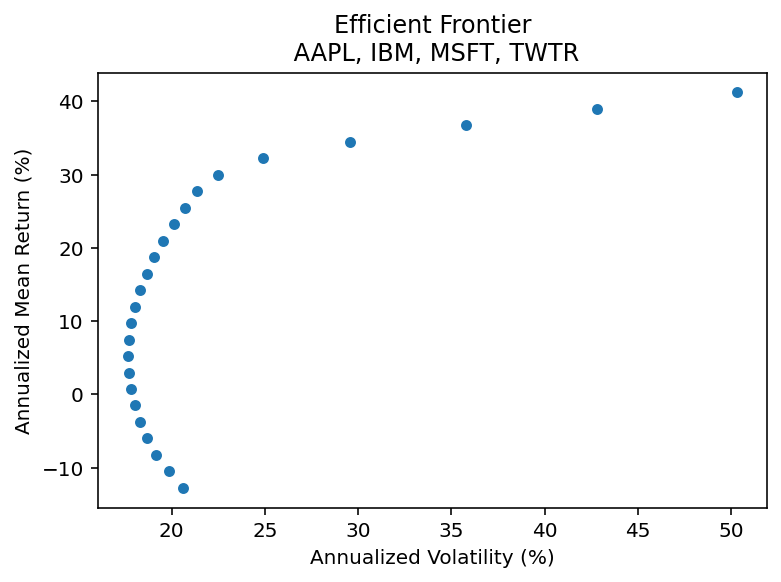

In [39]:
eff_frontier.mul(100).plot(x='std', y='tgt_ret', kind='scatter')
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(f'Efficient Frontier\n {", ".join(returns.columns)}')
plt.show()

## Practice

***Practice:***
Write functions for the following performance measures that Lewinson discusses:

> - Sharpe ratio: One of the most popular performance evaluation metrics, it measures the excess return (over the risk-free rate) per unit of standard deviation. When no risk-free rate is provided, the default assumption is that it is equal to 0%. The greater the Sharpe ratio, the better the portfolio's risk-adjusted performance.
> - Max drawdown: A metric of the downside risk of a portfolio, it measures the largest peak-to-valley loss (expressed as a percentage) during the course of the investment. The lower the maximum drawdown, the better.
> - Calmar ratio: The ratio is defined as the average annual compounded rate of return divided by the maximum drawdown for that same time period. The higher the ratio, the better.
> - Stability: Measured as the R-squared of a linear fit to the cumulative log returns. In practice, this means regressing a range of integers (serving as the time index) on cumulative log returns.
> - ~~Omega ratio: The probability-weighted ratio of gains over losses for a determined return target threshold (default set to 0). Its main advantage over the Sharpe ratio is that the Omega ratio—by construction—considers all moments of the returns distribution, while the former only considers the first two (mean and variance).~~
> - Sortino ratio: A modified version of the Sharpe ratio, where the standard deviation in the denominator is replaced with downside deviation.
> - Skew: Skewness measures the degree of asymmetry, that is, how much is the given distribution (here, of portfolio returns) more skewed than the Normal distribution. Negative skewness (left-skewed distributions) means  that large negative returns occur more frequently than large positive ones.
> - Kurtosis: Measures extreme values in either of the tails. Distributions with large kurtosis exhibit tail data exceeding the tails of the Gaussian distribution, meaning that large and small returns occur more frequently.
> - Tail ratio: The ratio (absolute) between the 95th and 5th percentile of the daily returns. A tail ratio of ~0.8 means that losses are ~1.25 times as bad as profits.
> - Daily value at risk: Calculated as $\mu - 2\sigma$, where $\mu$ is the average portfolio return over the period, and $\sigma$ the corresponding standard deviation.

Here are some tips:

1. Write functions that return decimal returns
1. For performance measures with benchmarks or targets, set the default to the risk-free rate of return from Ken French
1. Call these functions the lower-case version of the entry name with underscores instead of spaces

Also add:

1. Total return
1. Annual geometric mean return
1. Annual volatility

***For homework, try to write as many of the functions above as you can...***

In [40]:
ff_all = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900', session=session)
ff = ff_all[0].div(100).assign(Mkt = lambda x: x['Mkt-RF'] + x['RF'])

In [41]:
def sharpe_ratio(ri, tgt):
    ri_tgt = (ri - tgt).dropna()
    return np.sqrt(252) * ri_tgt.mean() / ri_tgt.std()

In [42]:
def drawdown(ri):
    implied_price = (1 + ri).cumprod()
    return implied_price / implied_price.cummax() - 1

In [43]:
def max_drawdown(ri):
    return drawdown(ri).min() # use .min() because drawdown() is negative

In [44]:
def cagr(ri):
    T = ri.shape[0]
    return (1 + ri).prod() ** (252/T) - 1

In [45]:
def calmar_ratio(ri):
    return cagr(ri) / (-1 * max_drawdown(ri))

In [46]:
def stability(ri):
    cumlogri = np.log(1 + ri).cumsum()
    time = np.arange(cumlogri.shape[0])
    df = pd.DataFrame({'cumlogri': cumlogri, 'time': time})
    import statsmodels.formula.api as smf
    fit = smf.ols(formula='cumlogri ~ time', data=df).fit()
    return fit.rsquared

In [47]:
def sortino_ratio(ri, tgt):
    ri_tgt = (ri - tgt).dropna()
    ri_tgt_downside = ri_tgt.loc[ri_tgt < 0]
    return np.sqrt(252) * ri_tgt.mean() / ri_tgt_downside.std()

In [48]:
def tail_ratio(ri):
    return np.abs(ri.quantile(0.95) / ri.quantile(0.05))

In [49]:
def daily_var(ri):
    return ri.mean() - 2 * ri.std()

In [50]:
def ann_std(ri):
    return np.sqrt(252) * ri.std()

In [51]:
def total_return(ri):
    return (1 + ri).prod() - 1

***Practice:***
Write a `tear_sheet()` function that tabulates average annual returns, cumulative returns, annual volatility, and the performance measures in the previous practice.

In [52]:
def tear_sheet(ri, tgt):
    name = ri.name
    begin = ri.index[0].strftime('%Y-%m-%d')
    end = ri.index[-1].strftime('%Y-%m-%d')

    df = pd.Series({
        'Name': name,
        'Begin': begin,
        'End': end,
        'Total Return (%)': 100 * total_return(ri=ri),
        'CAGR (%)': 100 * cagr(ri=ri),
        'Annual Volatility (%)': 100 * ann_std(ri=ri),
        'Sharpe Ratio': sharpe_ratio(ri=ri, tgt=tgt),
        'Max Drawdown (%)': 100 * max_drawdown(ri=ri),
        'Calmar Ratio': calmar_ratio(ri=ri),
        'Stability': stability(ri=ri),
        'Sortino Ratio': sortino_ratio(ri=ri, tgt=tgt),
        'Skew': ri.skew(),
        'Kurtosis': ri.kurt(),
        'Tail Ratio': tail_ratio(ri=ri),
        'Daily VaR (%)': 100 * daily_var(ri=ri),
    }).to_frame(name='Value')
    df.index.name = 'Performance Measure'
    
    return df

In [53]:
tear_sheet(ri=returns['AAPL'], tgt=ff['RF'])

,Value
Performance Measure,
Name,AAPL
Begin,2017-01-03
End,2018-12-31
Total Return (%),40.4618
CAGR (%),18.5968
Annual Volatility (%),23.8477
Sharpe Ratio,0.7794
Max Drawdown (%),-36.5095
Calmar Ratio,0.5094


***Practice:***
Find the portfolio with the maximum Sharpe Ratio for a portfolio of FAANG stocks from 2012 to 2019.
Note that `sco.minimize()` finds *minimums*, so you need to minimize the *negative* Sharpe Ratio.

In [54]:
maang = yf.download('META AAPL AMZN NFLX GOOG', session=session)['Adj Close'].pct_change()
maang.index = maang.index.tz_localize(None)

[*********************100%***********************]  5 of 5 completed


In [55]:
def sharpe_ratio(ri, tgt):
    ri_tgt = (ri - tgt).dropna()
    return np.sqrt(252) * ri_tgt.mean() / ri_tgt.std()

In [56]:
def neg_sharpe_ratio(w, rs, tgt):
    ri = rs.dot(w)
    return -1 * sharpe_ratio(ri=ri, tgt=tgt)

In [57]:
res_msr = sco.minimize(
    fun=neg_sharpe_ratio, # we want to minimize -1 * Sharpe Ratio
    x0=np.ones(maang.shape[1]) / maang.shape[1], # x0 contains our first guess at portfolio weights
    args=(maang.loc['2012':'2019'], ff['RF']), # args provides additional argument to the function we will minimize
    bounds=tuple([(0,1) for c in maang]), # bounds limits the search space for portfolio weights
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # "eq" constraints are driven to zero
    )
)
assert res_msr['success']

In [58]:
res_msr['x']

array([0.2903, 0.2683, 0.055 , 0.1047, 0.2818])

In [59]:
print_port_res(w=res_msr['x'], title='Maximum Sharpe Ratio Portfolio (2012-2019)', df=maang)

Maximum Sharpe Ratio Portfolio (2012-2019)

Performance
-----------
Return:     0.3016
Volatility: 0.2778

Weights
-------
AAPL:       0.2903
AMZN:       0.2683
GOOG:       0.0550
META:       0.1047
NFLX:       0.2818


***Practice:***
What is the *out-of-sample* performance of this maximum Sharpe Ratio portfolio?
For example, what is the Sharpe Ratio of this portfolio from 2020 through today?
How does this compare to the Sharpe Ratio of the $1/N$ portfolio?

They have (about) the same Sharpe Ratio!
Many portfolio optimization techniques fail to outperform in practice because out-of-sample correlations change!

In [60]:
sharpe_ratio(ri=maang.loc['2020':'2021'].dot(res_msr['x']), tgt=ff['RF'])

1.3350

In [61]:
sharpe_ratio(ri=maang.loc['2020':'2021'].mean(axis=1), tgt=ff['RF'])

1.3330

***Practice:***
Find the portfolio with the maximum Sharpe Ratio for a portfolio of FAANG stocks from 2010 to 2019, but allow short positions up to 30% of the portfolio.
So for every one dollar invested, you can short one or more of these four stocks to finance another 30 cents.

In [62]:
res_msr_short = sco.minimize(
    fun=neg_sharpe_ratio, # we want to minimize -1 * Sharpe Ratio
    x0=np.ones(maang.shape[1]) / maang.shape[1], # x0 contains our first guess
    args=(maang.loc['2012':'2019'], ff['RF']), # args provides additional arguments to `fun`
    bounds=tuple([(-0.3, 1.3) for c in maang]), # bounds limit our search space
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # portfolio weights sum to 1
        {'type': 'ineq', 'fun': lambda x: x[x < 0].sum() - (-0.3)} # sum of negative weights > -0.3
    )
)
assert res_msr_short['success']

In [63]:
print_port_res(
    w=res_msr_short['x'], 
    title='Maximum Sharpe Ratio Portfolio (2012-2019)\nwith Short Positions', 
    df=maang
)

Maximum Sharpe Ratio Portfolio (2012-2019)
with Short Positions

Performance
-----------
Return:     0.3015
Volatility: 0.2778

Weights
-------
AAPL:       0.2902
AMZN:       0.2681
GOOG:       0.0552
META:       0.1047
NFLX:       0.2817


With the FAANG stocks, allowing shorts does not increase the Sharpe Ratio!
However, allowing shorts increase the Sharpe Ratio with AAPL, IBM, MSFT, and TWTR!

In [64]:
res_msr_short_2 = sco.minimize(
    fun=neg_sharpe_ratio, # we want to minimize -1 * Sharpe Ratio
    x0=np.ones(returns.shape[1]) / returns.shape[1], # x0 contains our first guess
    args=(returns, ff['RF']), # args provides additional arguments to `fun`
    bounds=tuple([(-0.3, 1.3) for c in returns]), # bounds limit our search space
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # portfolio weights sum to 1
        {'type': 'ineq', 'fun': lambda x: x[x < 0].sum() - (-0.3)} # sum of negative weights > -0.3
    )
)
assert res_msr_short['success']

/home/richard/.local/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/richard/.local/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/richard/.local/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [65]:
print_port_res(
    w=res_msr_short_2['x'], 
    title='Maximum Sharpe Ratio Portfolio (2017-2018)\nwith Short Positions', 
    df=returns
)

Maximum Sharpe Ratio Portfolio (2017-2018)
with Short Positions

Performance
-----------
Return:     0.4252
Volatility: 0.2689

Weights
-------
AAPL:       0.0716
IBM:        -0.3000
MSFT:       1.1097
TWTR:       0.1187
